In [1]:
import scipy.io
import numpy as np
import time

import matplotlib.pyplot as plt
%matplotlib notebook

from IPython.display import clear_output
import os

from scipy.ndimage import convolve

# Setup 1

In [2]:
cam11 = scipy.io.loadmat("./cam1_1.mat")  # loads matlab files into python as a dict of np.ndarrays
cam11 = cam11["vidFrames1_1"].astype(np.float32)
cam21 = scipy.io.loadmat("./cam2_1.mat")["vidFrames2_1"].astype(np.float32)
cam31 = scipy.io.loadmat("./cam3_1.mat")["vidFrames3_1"].astype(np.float32)
cams = [cam11[:, :, :, 10:226], cam21[:, :, :, 17:233], cam31[:, :, :, 10:226]]

In [3]:
camsbw = []  # black and white
camavgs = []
for i, cam in enumerate(cams):
    cambw = cam[:, :, 0, :] * 0.2989 + cam[:, :, 1, :] * 0.5870 + cam[:, :, 2, :] * 0.1140  # convert to black and white
    camsbw.append(cambw)
    print("bw:", cambw.shape)
    camavg = np.mean(cambw, axis=2)
    camavgs.append(camavg)

bw: (480, 640, 216)
bw: (480, 640, 216)
bw: (480, 640, 216)


<IPython.core.display.Javascript object>


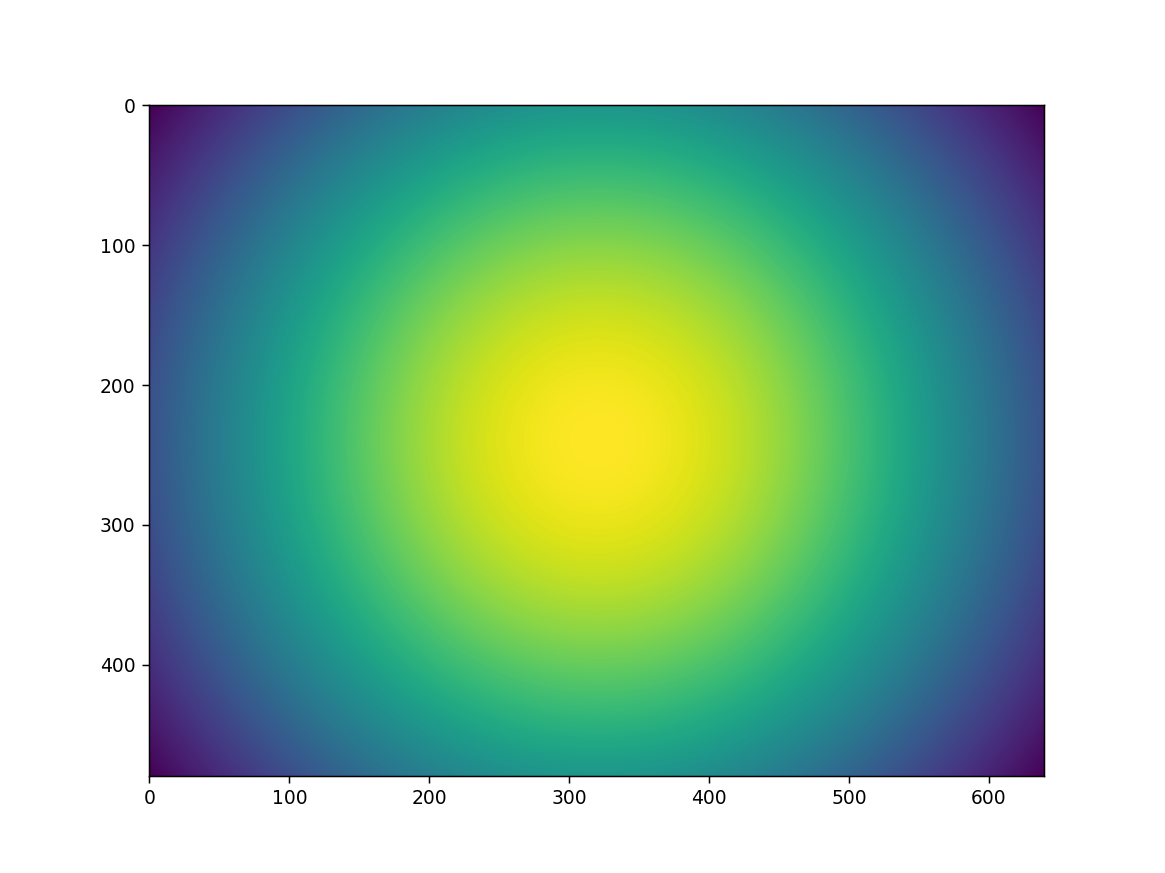

In [4]:
filtX, filtY = np.meshgrid(np.arange(camsbw[0].shape[1]), np.arange(camsbw[0].shape[0]))
scalex = 400
scaley = 400
filt = np.exp( -(filtX - 320)**2 / scalex**2 - (filtY - 240)**2 / scaley**2)
plt.figure()
plt.imshow(filt)
plt.show()

In [5]:
width = 10
kernelX, kernelY = np.meshgrid(np.arange(-width, width), np.arange(-width, width))
scale = 6
kernel = np.exp( -(kernelX)**2 / scale**2 - (kernelY)**2 / scale**2)

In [6]:
kernel.shape

(20, 20)

In [7]:
step = 1
camsdiff = []  # difference between 1 time step and the next
for i, cambw in enumerate(camsbw):
    camdiff = np.zeros((cambw.shape[0], cambw.shape[1], cambw.shape[2] // step))
    for t in range(0, cambw.shape[-1], step):
        camdiff[:, :, t // step] = convolve(abs(cambw[:, :, t] - camavgs[i]), kernel) * filt
    camdiff = abs(camdiff[:, :, 2:] - camdiff[:, :, :-2])
    camsdiff.append(camdiff)    
#     camsdiff.append(abs(cambw[:, :, 1:] - cambw[:, :, :-1]) * cambw[:, :, :-1])

In [8]:
camsdiff[0][100:200, 100:150:, 10]

array([[381.66109616, 386.18840999, 377.38039224, ..., 239.47532447,
        271.41006517, 295.47385609],
       [420.10480628, 417.93573901, 401.79299691, ..., 258.6141582 ,
        291.93218551, 316.6595364 ],
       [447.84609242, 438.52464844, 415.36971866, ..., 270.07805131,
        303.38679053, 327.59245918],
       ...,
       [ 45.71747936,  43.56101431,  40.25783838, ...,  92.67895857,
         97.10244141, 101.3804893 ],
       [ 54.7569781 ,  51.34869664,  46.84741013, ..., 101.4622535 ,
        106.60989752, 112.24472289],
       [ 63.0629036 ,  58.64292433,  53.17507769, ..., 108.08824544,
        113.57845652, 120.06909217]])

In [9]:
cam11.shape

(480, 640, 3, 226)

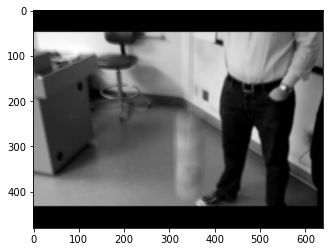

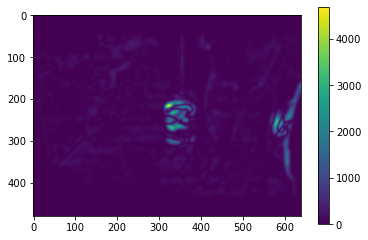

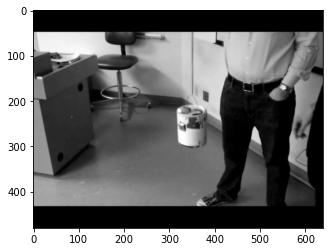

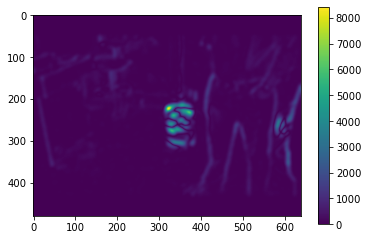

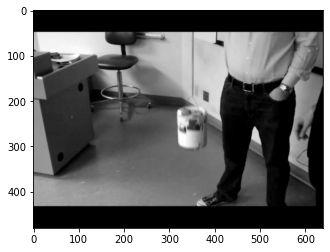

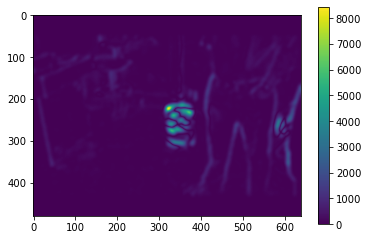

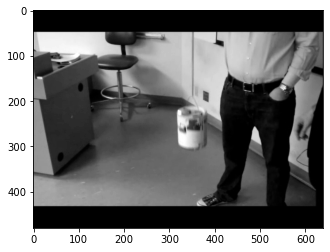

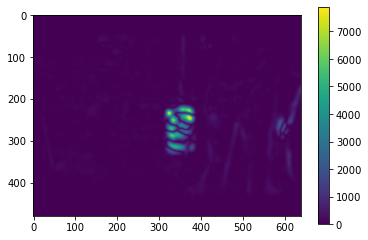

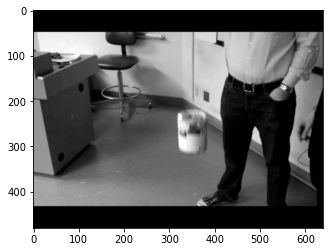

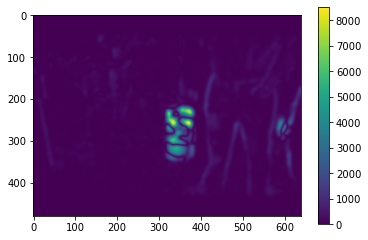

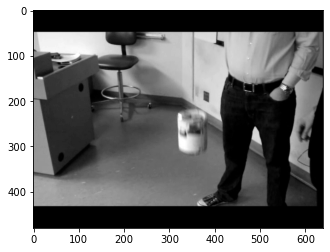

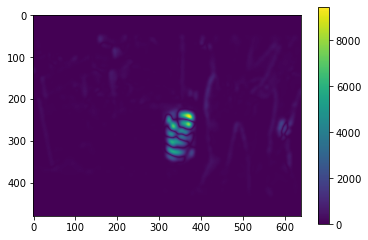

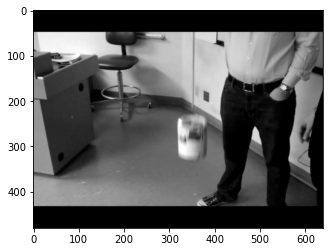

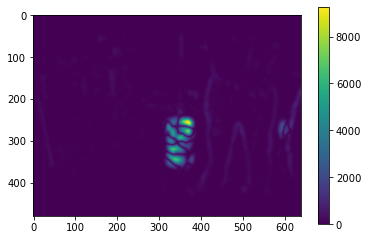

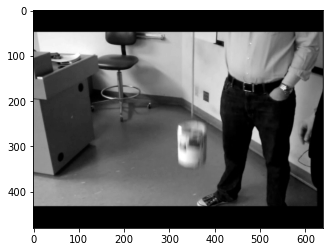

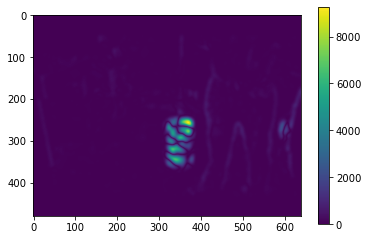

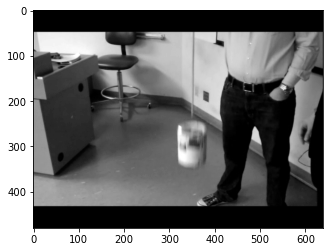

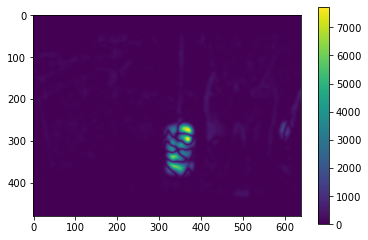

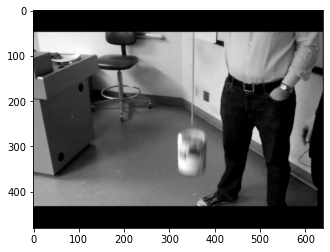

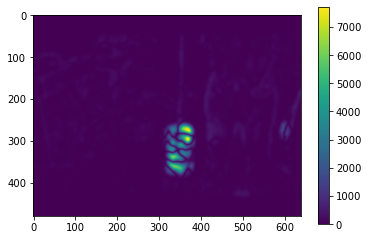

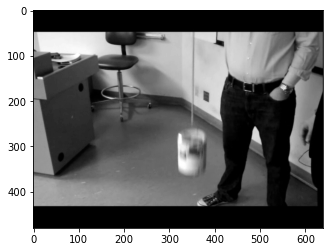

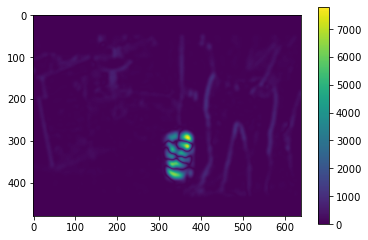

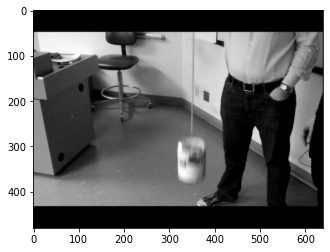

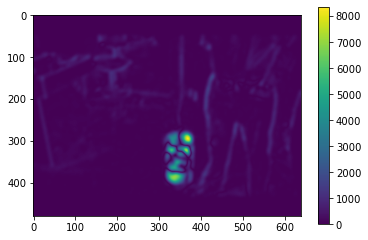

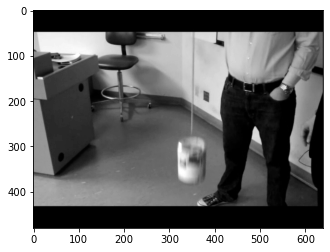

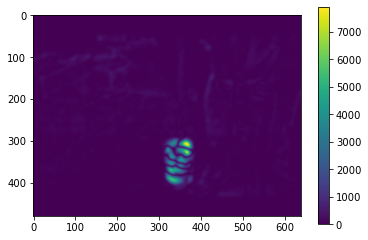

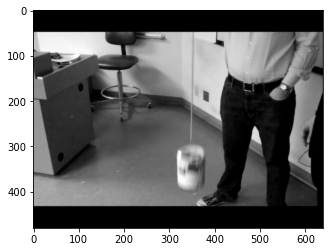

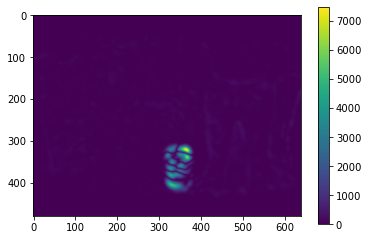

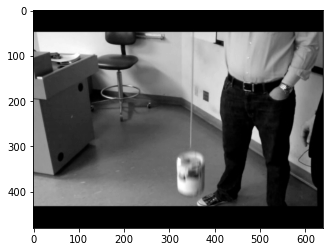

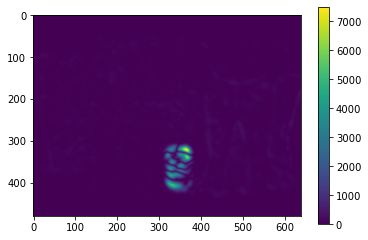

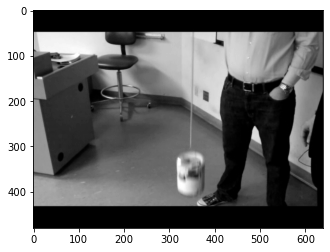

In [10]:
%matplotlib inline 
fig = plt.figure()
ax = fig.gca()
plt.imshow(camavgs[0], cmap="gray")
plt.show()
for i in range(0, 15, 1):
#     plt.imshow(np.log(abs(camsbw[0][:,:,i + 1] - camsbw[0][:,:,i]) + 1))
    plt.imshow(camsdiff[0][:,:,i])
    plt.colorbar()
    plt.show()
    plt.imshow(camsbw[0][:,:,i], cmap="gray")
    plt.show()



In [11]:
tmax = camsdiff[0].shape[-1]
# X = np.zeros((6, tmax), dtype=np.float32)
mn = 500
md = 1000
X = []
for t in range(tmax):
    i0, j0 = np.unravel_index(np.argmax(camsdiff[0][:,:,t]), camsdiff[0].shape[:2])
    i1, j1 = np.unravel_index(np.argmax(camsdiff[1][:,:,t]), camsdiff[1].shape[:2])
    i2, j2 = np.unravel_index(np.argmax(camsdiff[2][:,:,t]), camsdiff[2].shape[:2])
    if not (not X or (i0 - X[-1][0])**2 + (j0 - X[-1][1])**2 < md**2):
        i0 = X[-1][0]
        j0 = X[-1][1]
    if not (not X or (i1 - X[-1][2])**2 + (j1 - X[-1][3])**2 < md**2):
        i1 = X[-1][2]
        j1 = X[-1][3]
    if not (not X or (i2 - X[-1][4])**2 + (j2 - X[-1][5])**2 < md**2):
        i2 = X[-1][4]
        j2 = X[-1][5]
        
    if camsdiff[0][i0, j0, t] > mn and camsdiff[1][i1, j1, t] > mn and camsdiff[2][i2, j2, t] > mn:
        X.append(np.array([i0, j0, i1, j1, i2, j2]))
    elif X:
        X.append(X[-1])
X = np.transpose(np.array(X, dtype=np.float32))

# tmax = camsdiff[0].shape[-1]
# # X = np.zeros((6, tmax), dtype=np.float32)
# mn = 100
# i0, j0 = np.unravel_index(np.argmax(camsdiff[0][:,:,0]), camsdiff[0].shape[:2])
# i1, j1 = np.unravel_index(np.argmax(camsdiff[1][:,:,0]), camsdiff[1].shape[:2])
# i2, j2 = np.unravel_index(np.argmax(camsdiff[2][:,:,0]), camsdiff[2].shape[:2])
# X = [[i0, j0, i1, j1, i2, j2]]

# for t in range(tmax):
#     found = False
#     kth = 0
#     while not found:
#         i0, j0 = np.unravel_index(np.argpartition(camsdiff[0][:,:,t], kth, axis=None)[kth], camsdiff[0].shape[:2])
#         if (i0 - X[-1][0])**2 + (j0 - X[-1][1])**2 < 10**2:
#             found = True
#         kth += 1
    
#     found = False
#     kth = 0
#     while not found:
#         i1, j1 = np.unravel_index(np.argpartition(camsdiff[1][:,:,t], kth, axis=None)[kth], camsdiff[1].shape[:2])
#         if (i1 - X[-1][2])**2 + (j1 - X[-1][3])**2 < 10**2:
#             found = True
#         kth += 1
    
#     found = False
#     kth = 0
#     while not found:
#         i2, j2 = np.unravel_index(np.argpartition(camsdiff[2][:,:,t], kth, axis=None)[kth], camsdiff[2].shape[:2])
#         if (i2 - X[-1][4])**2 + (j2 - X[-1][5])**2 < 10**2:
#             found = True
#         kth += 1
        
#     X.append([i0, j0, i1, j1, i2, j2])
# X = np.transpose(np.array(X, dtype=np.float32))

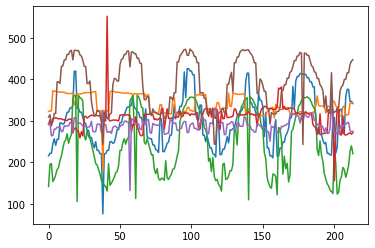

In [12]:
plt.figure()
plt.plot(np.transpose(X)[:, :])
plt.show()

In [13]:
cov = X @ np.transpose(X) / (X.shape[-1] - 1)

In [14]:
L, V = np.linalg.eig(cov)

In [15]:
Y = np.transpose(V) @ X
covY = Y @ np.transpose(Y)
print(covY)

[[ 1.27542240e+08 -4.31903458e+00 -8.65916252e+00 -8.64105988e+00
  -1.68521595e+00 -4.05663729e+00]
 [-4.31903458e+00  1.26613712e+06 -1.36423035e+01 -2.01214027e+00
   1.35175962e+01  5.27967548e+00]
 [-8.65916252e+00 -1.36423035e+01  3.39669438e+05  1.39269085e+01
  -1.22675791e+01 -4.23013735e+00]
 [-8.64105988e+00 -2.01214027e+00  1.39269085e+01  2.20298531e+05
   3.99856353e+00 -9.32850838e-01]
 [-1.68521595e+00  1.35175962e+01 -1.22675791e+01  3.99856353e+00
   1.31074688e+05  3.96666837e+00]
 [-4.05663729e+00  5.27967548e+00 -4.23013735e+00 -9.32850838e-01
   3.96666837e+00  8.57980000e+04]]


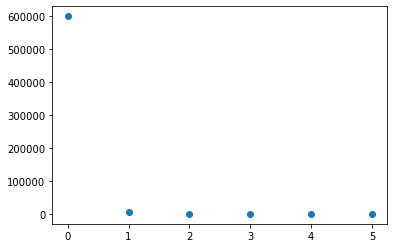

In [18]:
plt.figure()
plt.scatter(np.arange(len(L)), L)
plt.show()

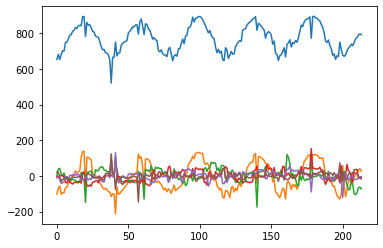

In [17]:
plt.figure()
plt.plot(np.transpose(Y))
plt.show()

In [63]:
help( np.linalg.eig)

Help on function eig in module numpy.linalg:

eig(a)
    Compute the eigenvalues and right eigenvectors of a square array.
    
    Parameters
    ----------
    a : (..., M, M) array
        Matrices for which the eigenvalues and right eigenvectors will
        be computed
    
    Returns
    -------
    w : (..., M) array
        The eigenvalues, each repeated according to its multiplicity.
        The eigenvalues are not necessarily ordered. The resulting
        array will be of complex type, unless the imaginary part is
        zero in which case it will be cast to a real type. When `a`
        is real the resulting eigenvalues will be real (0 imaginary
        part) or occur in conjugate pairs
    
    v : (..., M, M) array
        The normalized (unit "length") eigenvectors, such that the
        column ``v[:,i]`` is the eigenvector corresponding to the
        eigenvalue ``w[i]``.
    
    Raises
    ------
    LinAlgError
        If the eigenvalue computation does not converg

In [93]:
X.shape

(6, 60)